Your goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations. <br>
Goal: What species of dogs most frequently appear on WeRateDogs Twitter <br>
What species of dogs get the most likes per tweet <br>
Does high rating correlate to high likes?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import requests
import tweepy
import json
import os
import time
import csv
%matplotlib inline

## Gathering Data

The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

Each tweet's retweet count and favorite (i.e. "like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

#### twitter-archive-enhanced.csv

In [3]:
twitter_archive_enhanced_df = pd.read_csv('twitter-archive-enhanced.csv')

In [6]:
twitter_archive_enhanced_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
twitter_archive_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
twitter_archive_enhanced_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


#### image-predictions.tsv

In [3]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [8]:
with open('image-predictions.tsv', mode='wb') as file:
    file.write(r.content)

In [11]:
os.listdir('./')

['twitter-archive-enhanced.csv',
 '.ipynb_checkpoints',
 'wrangle_act.ipynb',
 'image-predictions.tsv']

In [6]:
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [85]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [8]:
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### tweet_json.txt

In [30]:
consumer_key = 'xx'
consumer_secret = 'xx'
access_token = 'xx'
access_secret = 'xx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [5]:
# reference: https://stackoverflow.com/questions/1039877/crunching-json-with-python
# reference: https://docs.python.org/3/tutorial/errors.html
'''
error_id_list = []
with open('tweet_json.txt', mode='w') as file:
    for tweet_id in twitter_archive_enhanced_df.tweet_id:
        start = time.time()
        print(tweet_id)
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            tweet_json_line = json.dumps(tweet._json)
            file.write(tweet_json_line + '\n')
            end = time.time()
            print(end - start)
        except Exception:
            error_id_list.append(tweet_id)
''';

In [9]:
# reference: https://stackoverflow.com/questions/10393176/is-there-a-way-to-read-a-txt-file-and-store-each-line-to-memory
# Is there a more elegant way of doing this?
keys = ['id', 'retweet_count', 'favorite_count'];
tweet_api_df = pd.DataFrame([])
json_df = pd.DataFrame()
with open('tweet_json.txt', 'r') as file:
    reader = file.readlines()
    for row_index, row in enumerate(reader):
        json_row_data = json.loads(row)
        json_dict_data = {}
        for i in keys:
            json_dict_data[i] = json_row_data[i]
        json_df = pd.DataFrame(json_dict_data, index=[row_index])
        tweet_api_df = tweet_api_df.append(json_df)




In [5]:
tweet_api_df.head()

,favorite_count,id,retweet_count
0,39294,892420643555336193,8773
1,33648,892177421306343426,6426
2,25343,891815181378084864,4268
3,42663,891689557279858688,8858
4,40812,891327558926688256,9639


In [10]:
tweet_api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2349 entries, 0 to 2348
Data columns (total 3 columns):
favorite_count    2349 non-null int64
id                2349 non-null int64
retweet_count     2349 non-null int64
dtypes: int64(3)
memory usage: 73.4 KB


In [11]:
tweet_api_df.describe()

,favorite_count,id,retweet_count
count,2349.000000,2.349000e+03,2349.000000
mean,8107.331630,7.424674e+17,3093.799489
std,12058.829012,6.840987e+16,5128.569083
min,0.000000,6.660209e+17,0.000000
25%,1413.000000,6.783890e+17,615.000000
50%,3585.000000,7.193325e+17,1443.000000
75%,10090.000000,7.989257e+17,3600.000000
max,131708.000000,8.924206e+17,78669.000000


#### Creating Master Data Frame

In [12]:
twitter_archive_master_full_df = twitter_archive_enhanced_df.set_index('tweet_id').join(tweet_api_df.set_index('id'));
twitter_archive_master_full_df.reset_index(inplace=True);
twitter_archive_master_full_df = twitter_archive_master_full_df.set_index('tweet_id').join(image_predictions_df.set_index('tweet_id'));
twitter_archive_master_full_df.reset_index(inplace=True);

In [20]:
twitter_archive_master_full_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [36]:
twitter_archive_master_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

## Assessing Data

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

In [8]:
# Define tidy 1: doggo, floofer, pupper, puppo
twitter_archive_enhanced_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [91]:
# Define quality 3: twitter api
tweet_api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2349 entries, 0 to 2348
Data columns (total 3 columns):
favorite_count    2349 non-null int64
id                2349 non-null int64
retweet_count     2349 non-null int64
dtypes: int64(3)
memory usage: 73.4 KB


In [13]:
# Define quality 4: image-prediction
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [37]:
twitter_archive_master_full_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2349.000000,2349.000000,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,8107.331630,3093.799489,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,12058.829012,5128.569083,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,0.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,1413.000000,615.000000,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,3585.000000,1443.000000,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,10090.000000,3600.000000,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,131708.000000,78669.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


(9, 19)

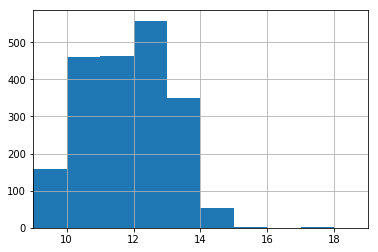

In [38]:
# Define quality 2: numerator
twitter_archive_master_full_df['rating_numerator'].hist(bins=10, range=(9,19))
plt.xlim((9,19))

In [10]:
# Define quality 2: numerator
twitter_archive_master_full_df['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [7]:
# Define quality 1: denominator
twitter_archive_master_full_df['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [21]:
twitter_p1_df = twitter_archive_master_full_df.groupby(['p1']).count()

In [6]:
# Define quality 7: 0 favorites
twitter_archive_master_full_df[twitter_archive_master_full_df['favorite_count']==0].count()

tweet_id                      174
in_reply_to_status_id           0
in_reply_to_user_id             0
timestamp                     174
source                        174
text                          174
retweeted_status_id           174
retweeted_status_user_id      174
retweeted_status_timestamp    174
expanded_urls                 173
rating_numerator              174
rating_denominator            174
name                          174
doggo                         174
floofer                       174
pupper                        174
puppo                         174
favorite_count                174
retweet_count                 174
jpg_url                        76
img_num                        76
p1                             76
p1_conf                        76
p1_dog                         76
p2                             76
p2_conf                        76
p2_dog                         76
p3                             76
p3_conf                        76
p3_dog        

In [10]:
twitter_ratingD_df = twitter_archive_master_full_df.groupby(['rating_denominator']).count()

In [11]:
# Define quality 1: denominator
twitter_ratingD_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
rating_denominator,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
7,1,0,0,1,1,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
10,2333,73,73,2333,2333,2333,180,180,180,2278,...,2057,2057,2057,2057,2057,2057,2057,2057,2057,2057
11,3,0,0,3,3,3,1,1,1,3,...,2,2,2,2,2,2,2,2,2,2
15,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,2,1,1,2,2,2,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
40,1,0,0,1,1,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1


In [8]:
# Define quality 2: numerator
twitter_ratingN_df = twitter_archive_master_full_df.groupby(['rating_numerator']).count()
twitter_ratingN_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
rating_numerator,,,,,,,,,,,,,,,,,,,,,
0,2,1,1,2,2,2,0,0,0,2,...,2,2,2,2,2,2,2,2,2,2
1,9,3,3,9,9,9,1,1,1,6,...,5,5,5,5,5,5,5,5,5,5
2,9,0,0,9,9,9,0,0,0,9,...,9,9,9,9,9,9,9,9,9,9
3,19,0,0,19,19,19,0,0,0,19,...,19,19,19,19,19,19,19,19,19,19
4,17,1,1,17,17,17,0,0,0,16,...,16,16,16,16,16,16,16,16,16,16
5,37,2,2,37,37,37,1,1,1,35,...,34,34,34,34,34,34,34,34,34,34
6,32,0,0,32,32,32,0,0,0,32,...,32,32,32,32,32,32,32,32,32,32
7,55,2,2,55,55,55,1,1,1,53,...,52,52,52,52,52,52,52,52,52,52
8,102,0,0,102,102,102,4,4,4,102,...,95,95,95,95,95,95,95,95,95,95


In [32]:
twitter_archive_master_full_df[twitter_archive_master_full_df['rating_denominator']== 7]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",...,1.0,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True


In [15]:
# Define quality 5: bad tweets
twitter_archive_master_full_df[twitter_archive_master_full_df['tweet_id']== 892420643555336193][['p1', 'p2','p3']]

,p1,p2,p3
0,orange,bagel,banana


In [16]:
# Define quality 6: bad predictions
twitter_archive_master_full_df[twitter_archive_master_full_df['tweet_id']== 666268910803644416][['p1', 'p2','p3']]

,p1,p2,p3
2337,desktop_computer,desk,bookcase


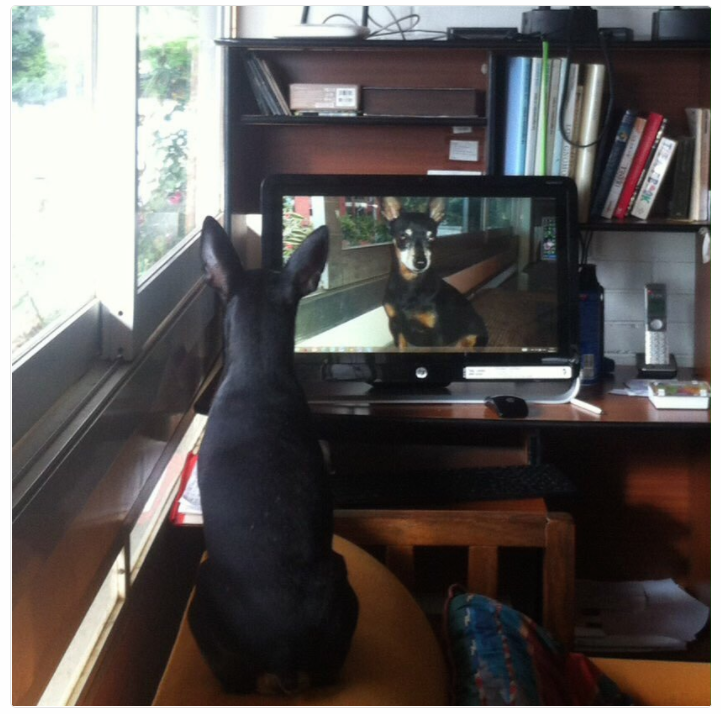

In [19]:
# Define quality 7: tweepy reliability
twitter_archive_master_full_df[twitter_archive_master_full_df['tweet_id']==886053434075471873]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


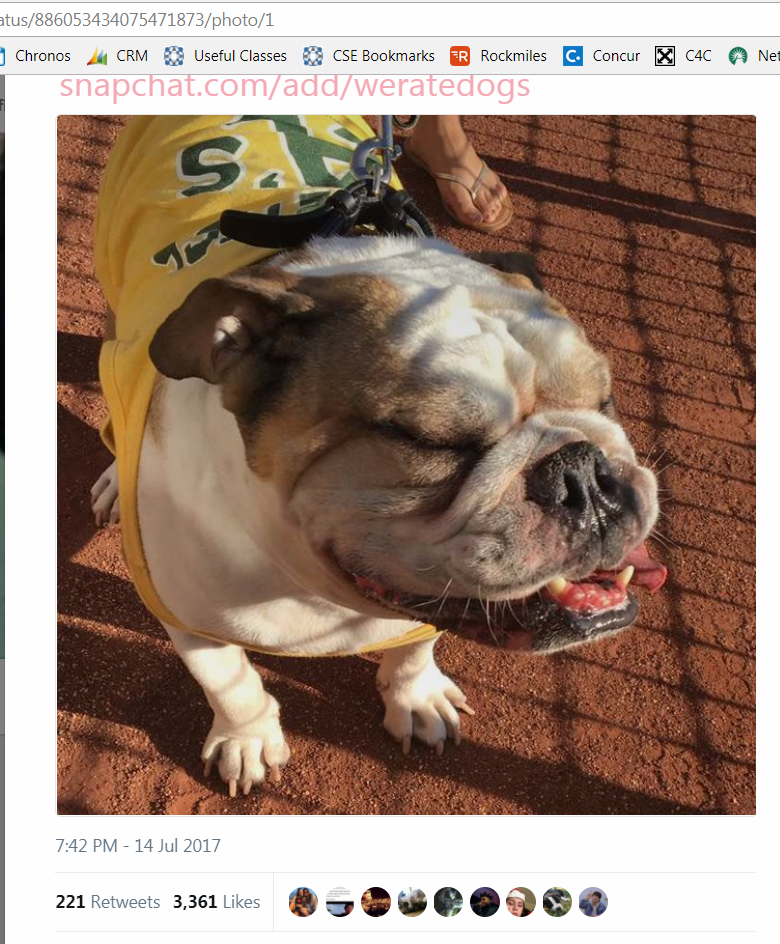

In [9]:
# Define quality 8: retweet = 0
twitter_archive_master_full_df[twitter_archive_master_full_df['retweet_count']==0]['tweet_id']

291    838085839343206401
Name: tweet_id, dtype: int64

In [20]:
# Define tidy 2: p1, p2, p3 collapse 
twitter_archive_master_full_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


### Quality Issues
- Denominator should only be equal to 10. Tweets with denominator not equal to 10 are for multiple dogs or special circumstances such as 9/11 and 24/7.
- Numerator should be between 10 and 14. Other values might be intentional. Checked 1776/10 (tweet id 749981277374128128), the dog is dressed up in US flag. Tweets with 8 or 9 numerators sometimes contain dogs. 7 and below are questionable.
- Twitter API was able to locate 2349 of 2356 tweets in twitter-archive-enhanced.csv. The 7 unlocatable tweets should be omitted.
- Neural network produced image-prediction file mapped 2075 of 2356 tweets in twitter-archive-enhanced.csv. The unmatched tweets should be omitted.
- Not all image-predictions were of dogs. For example, tweet id 892420643555336193 had predictions of orange, bagel, and banana. 
- Not all predictions are accurate. For example, tweet 666268910803644416 did not locate a dog in the image when there is a dog.
- Not all favorite count information were collectible through API. For example, tweet 886053434075471873 had favorite_count = 0 in our dataframe, but had 3,364 likes when checked on twitter. The tweets with 0 favorites will be dropped. Most if not all valid WeRateDogs tweets had more than 0 likes.
- Not all tweets were rating dogs. For example 838085839343206401 had zero retweets with the message "we are still looking for the first 15/10."

### Tidy Issues
- twitter-archive-enhanced.csv's doggo, floofer, pupper, and puppo columns should be merged into one column
- p1, p2, and p3 are probabilities of image prediction. It would be cleaner to have the most likely dog prediction. If the image is not of a dog, then the image prediction should return the most likely item or omitted.

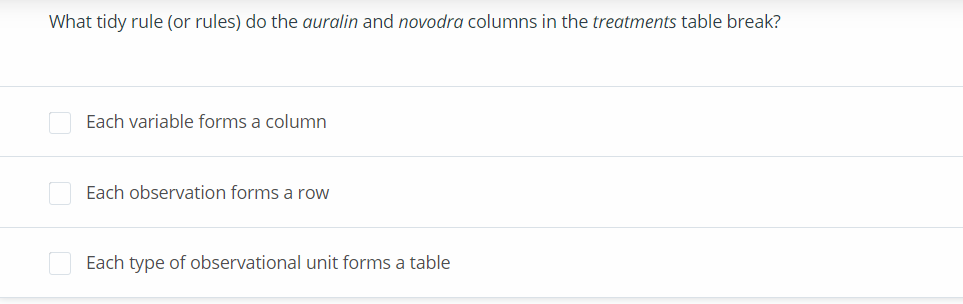

## Cleaning Data

Clean each of the issues you documented while assessing. Perform this cleaning in wrangle_act.ipynb as well. The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate). Again, the issues that satisfy the Project Motivation must be cleaned.

# Quality Issues

## Define

1-Keeping tweets with denominator = 10


2-Keeping tweets with numerator between 8 and 14

3-Keeping rows with valid favorite and retweet counts

4-Keeping rows with p1_dog, p2_dog, or p3_dog = True. Only keeping entries that we can predict as dog and its species.

# Code

In [22]:
# Code Quality: Keeping tweets with denominator = 10
twitter_archive_master_df = twitter_archive_master_full_df[twitter_archive_master_full_df['rating_denominator'] == 10]

In [23]:
# Code Quality: Keeping tweets with numerator between 8 and 14
twitter_archive_master_df = twitter_archive_master_df[((twitter_archive_master_df['rating_numerator'] >= 8) &
                                                       (twitter_archive_master_df['rating_numerator'] <=14))]

In [24]:
# Code Quality: Keeping rows with valid favorite and retweet counts
# source: https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan
twitter_archive_master_df = twitter_archive_master_df[np.isfinite(twitter_archive_master_df['favorite_count'])]
twitter_archive_master_df = twitter_archive_master_df[np.isfinite(twitter_archive_master_df['retweet_count'])]

In [25]:
# Code Quality: Keeping rows with p1_dog, p2_dog, or p3_dog = True. Only keeping entries that we can predict as dog and its species.
twitter_archive_master_df = twitter_archive_master_df[((twitter_archive_master_df['p1_dog'] == True) |
                                                       (twitter_archive_master_df['p2_dog'] == True) |
                                                      (twitter_archive_master_df['p3_dog'] == True))]

# Tidy Issues

## Define

1-Combining doggo, floofer, pupper, puppo into one column.



2- Consulidating image prediction into one column.

3-Drop unneeded columns

## Code

In [26]:
# Code Tidy: Combining doggo, floofer, pupper, puppo into one column
# source: https://stackoverflow.com/questions/23743460/replacing-none-with-nan-in-pandas
# source: https://stackoverflow.com/questions/29782898/combine-pandas-data-frame-column-values-into-new-column
twitter_archive_master_df['doggo'].replace('None', np.nan, inplace=True)
twitter_archive_master_df['floofer'].replace('None', np.nan, inplace=True)
twitter_archive_master_df['pupper'].replace('None', np.nan, inplace=True)
twitter_archive_master_df['puppo'].replace('None', np.nan, inplace=True)
twitter_archive_master_df['DoggoLingo'] = twitter_archive_master_df[['doggo','floofer','pupper','puppo']].fillna('').sum(axis=1)

In [27]:
# Code Tidy: Consulidating image prediction into one column
twitter_archive_master_df['dog_species1'] = twitter_archive_master_df[twitter_archive_master_df['p1_dog'] == True].p1
twitter_archive_master_df['dog_species2'] = twitter_archive_master_df[((twitter_archive_master_df['p1_dog'] == False) &
                                                                     (twitter_archive_master_df['p2_dog'] == True))].p2
twitter_archive_master_df['dog_species3'] = twitter_archive_master_df[((twitter_archive_master_df['p1_dog'] == False) &
                                                                     (twitter_archive_master_df['p2_dog'] == False) &
                                                                     (twitter_archive_master_df['p3_dog'] == True))].p3
twitter_archive_master_df['dog_species'] = twitter_archive_master_df[['dog_species1','dog_species2','dog_species3']].fillna('').sum(axis=1)

## Test

In [28]:
# Test
twitter_archive_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651 entries, 1 to 2355
Data columns (total 35 columns):
tweet_id                      1651 non-null int64
in_reply_to_status_id         19 non-null float64
in_reply_to_user_id           19 non-null float64
timestamp                     1651 non-null object
source                        1651 non-null object
text                          1651 non-null object
retweeted_status_id           60 non-null float64
retweeted_status_user_id      60 non-null float64
retweeted_status_timestamp    60 non-null object
expanded_urls                 1651 non-null object
rating_numerator              1651 non-null int64
rating_denominator            1651 non-null int64
name                          1651 non-null object
doggo                         68 non-null object
floofer                       8 non-null object
pupper                        177 non-null object
puppo                         23 non-null object
favorite_count                1651 non-null

## Code

In [29]:
# Code Tidy: Drop unneeded columns
twitter_archive_master_df = twitter_archive_master_df[['tweet_id', 'timestamp', 'rating_numerator', 'rating_denominator', 
                                                       'favorite_count', 'retweet_count', 'DoggoLingo', 'dog_species']]

In [30]:
# Code Quality: Drop tweets with 0 favorite counts
twitter_archive_master_df = twitter_archive_master_df[twitter_archive_master_full_df['favorite_count'] > 0];

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Test

In [31]:
# Test
twitter_archive_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1591 entries, 1 to 2355
Data columns (total 8 columns):
tweet_id              1591 non-null int64
timestamp             1591 non-null object
rating_numerator      1591 non-null int64
rating_denominator    1591 non-null int64
favorite_count        1591 non-null float64
retweet_count         1591 non-null float64
DoggoLingo            1591 non-null object
dog_species           1591 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 111.9+ KB


In [32]:
# Test
twitter_archive_master_df.head(2)

,tweet_id,timestamp,rating_numerator,rating_denominator,favorite_count,retweet_count,DoggoLingo,dog_species
1,892177421306343426,2017-08-01 00:17:27 +0000,13,10,33648.0,6426.0,,Chihuahua
2,891815181378084864,2017-07-31 00:18:03 +0000,12,10,25343.0,4268.0,,Chihuahua


## Storing, Analyzing, and Visualizing Data

Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least three (3) insights and one (1) visualization must be produced.

Goal: What species of dogs most frequently appear on WeRateDogs Twitter 
What species of dogs get the most likes per tweet 
Does high rating correlate to high likes?

In [27]:
twitter_archive_master_df.to_csv('twitter_archive_master.csv', sep= ',', encoding = 'utf-8')

In [2]:
twitter_archive_master_df = pd.read_csv('twitter_archive_master.csv')

In [3]:
# What species of dogs most frequently appear on WeRateDogs Twitter 
dog_species_df = twitter_archive_master_df.groupby(['dog_species']).count();
dog_species_fav_df = twitter_archive_master_df.groupby(['dog_species']).sum();
dog_species_df['fav_per_tweet']= dog_species_fav_df['favorite_count']/dog_species_df['tweet_id'];
dog_species_df['retweet_per_tweet']= dog_species_fav_df['retweet_count']/dog_species_df['tweet_id'];

In [4]:
dog_species_df.sort_values(['tweet_id'], ascending = False).head(5)

,Unnamed: 0,tweet_id,timestamp,rating_numerator,rating_denominator,favorite_count,retweet_count,DoggoLingo,fav_per_tweet,retweet_per_tweet
dog_species,,,,,,,,,,
golden_retriever,153,153,153,153,153,153,153,34,12113.954248,3647.535948
Labrador_retriever,104,104,104,104,104,104,104,19,12028.865385,3816.153846
Pembroke,91,91,91,91,91,91,91,13,11245.175824,3138.527473
Chihuahua,82,82,82,82,82,82,82,9,8771.804878,2851.621951
pug,58,58,58,58,58,58,58,11,6507.965517,2000.379310


In [5]:
dog_species_df.sort_values(['fav_per_tweet'], ascending = False).head(10)

,Unnamed: 0,tweet_id,timestamp,rating_numerator,rating_denominator,favorite_count,retweet_count,DoggoLingo,fav_per_tweet,retweet_per_tweet
dog_species,,,,,,,,,,
black-and-tan_coonhound,1,1,1,1,1,1,1,1,33634.000000,8186.000000
Saluki,4,4,4,4,4,4,4,0,23894.000000,5075.000000
Afghan_hound,2,2,2,2,2,2,2,0,22231.000000,7908.500000
Bedlington_terrier,5,5,5,5,5,5,5,2,21792.600000,8258.400000
flat-coated_retriever,7,7,7,7,7,7,7,1,18821.142857,5029.857143
French_bulldog,31,31,31,31,31,31,31,4,18666.000000,5065.193548
Bouvier_des_Flandres,1,1,1,1,1,1,1,0,17846.000000,4431.000000
Irish_water_spaniel,3,3,3,3,3,3,3,1,16255.666667,4443.666667
English_springer,9,9,9,9,9,9,9,2,15552.888889,5915.777778


In [9]:
twitter_archive_master_df[twitter_archive_master_df['dog_species'] == 'black-and-tan_coonhound'].tweet_id

138    854120357044912130
Name: tweet_id, dtype: int64

In [37]:
# source: https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(twitter_archive_master_df['rating_numerator'],
                                                                     twitter_archive_master_df['favorite_count'])
print('Slope='+str(slope)+"; Intercept=" + str(intercept)+ '; R-Value='+ str(r_value) +
     '; P-Value=' + str(p_value) + '; STD-Error=' + str(std_err))

Slope=4552.77481019; Intercept=-40907.4415336; R-Value=0.481569475901; P-Value=3.78486883853e-93; STD-Error=207.855519992


In [30]:
# source: https://plot.ly/matplotlib/linear-fits/
xi = np.arange(8,15)
line = slope*xi+intercept

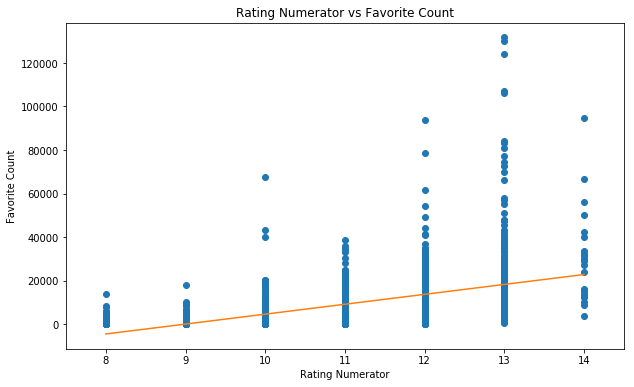

In [59]:
# source: https://stackoverflow.com/questions/2051744/reverse-y-axis-in-pyplot
twitter_archive_master_df.plot(x='rating_numerator', y='favorite_count', style='o', figsize=(10,6), legend=None)
plt.plot(xi, line)
plt.gca().invert_xaxis()
plt.xlim((7.5,14.5))
plt.ylabel('Favorite Count')
plt.xlabel('Rating Numerator')
plt.title('Rating Numerator vs Favorite Count');

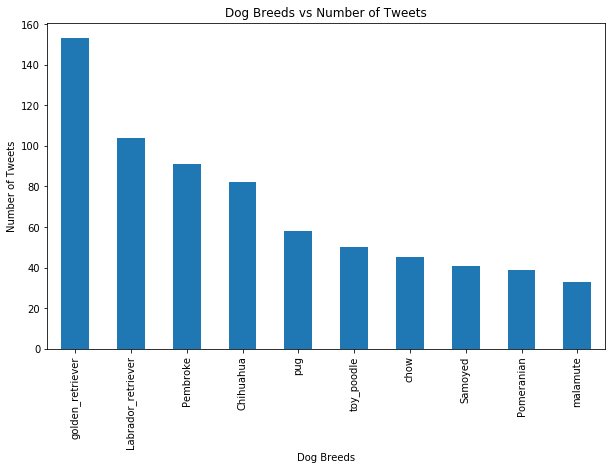

In [116]:
dog_popular10_df = dog_species_df.sort_values(['tweet_id'], ascending = False).head(10)
dog_popular10_df = dog_popular10_df.reset_index()
dog_popular10_df.plot(x='dog_species', y='tweet_id', kind='bar', figsize=(10,6), legend=None);
plt.ylabel('Number of Tweets')
plt.xlabel('Dog Breeds')
plt.title('Dog Breeds vs Number of Tweets');

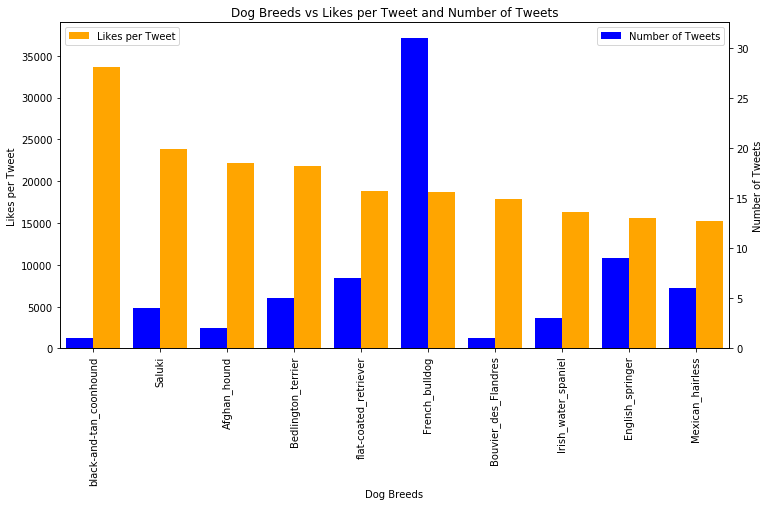

In [114]:
# source: https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis
# source: https://stackoverflow.com/questions/24738186/define-aspect-ratio-when-using-twinx
dog_fav10_df = dog_species_df.sort_values(['fav_per_tweet'], ascending = False).head(10)
dog_fav10_df = dog_fav10_df.reset_index()

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

plot1 = dog_fav10_df.plot(x='dog_species', y='fav_per_tweet', kind='bar', color = 'orange',
                  width=width, ax=ax, position = 0, figsize=(12,6), label = 'Likes per Tweet')
plot2 = dog_fav10_df.plot(x='dog_species', y='tweet_id', kind='bar', color = 'blue',
                  width=width, ax=ax2, position = 1, figsize=(12,6), label = 'Number of Tweets')

ax.set_ylabel('Likes per Tweet')
plot1.legend(loc=2)
ax.set(adjustable='box-forced', ylim=(0,39000))
ax2.set_ylabel('Number of Tweets')
ax.set_xlabel('Dog Breeds')
plt.xlim((-0.5,9.5))
plt.title('Dog Breeds vs Likes per Tweet and Number of Tweets');

#### Insights
- The most common dog species from WeRateDogs over the time period 11/15/2015 and 8/1/2017 is golden retriever.
- The dog species that received the highest likes per tweet was "black and tan coonhound." This species only had 1 tweet. The tweet is below if interested.
- There is moderate correlation between rating numerator and favorite count. Higher rater numerator generally generates higher favorite counts. This correlation is moderate with a R-Squared value of 0.48 and Standard Error of 208.

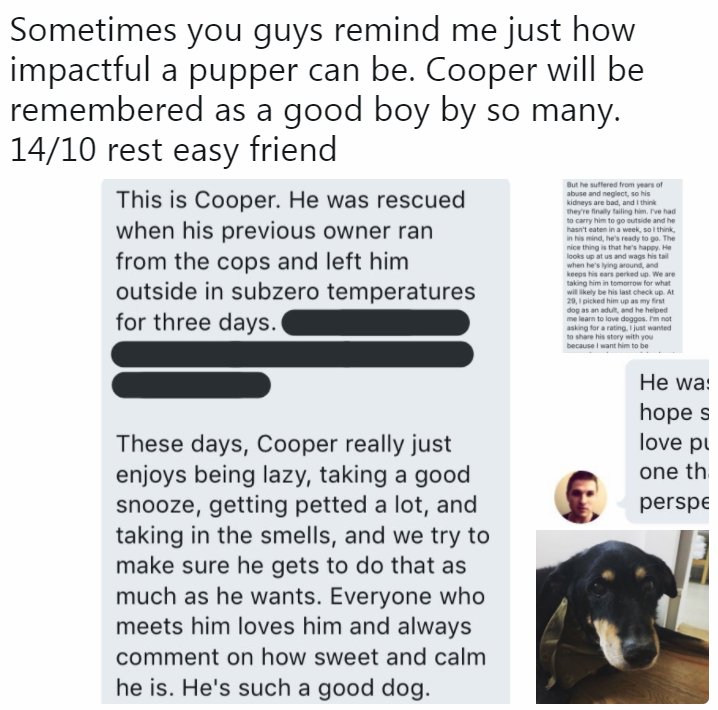

## Report

Create a 300-600 word written report called wrangle_report.pdf that briefly describes your wrangling efforts. This is to be framed as an internal document.

Create a >250 word written report called act_report.pdf that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.

Both of these documents can be created in separate Jupyter Notebooks using the Markdown functionality of Jupyter Notebooks, then downloading those notebooks as PDF files (see image below). You might prefer to use a word processor like Google Docs or Microsoft Word, however.

wrangle_act.ipynb: code for gathering, assessing, cleaning, analyzing, and visualizing data <br>
wrangle_report.pdf: documentation for data wrangling steps: gather, assess, and clean <br>
act_report.pdf: documentation of analysis and insights into final data <br>
twitter_archive_enhanced.csv: file as given <br>
image_predictions.tsv: file downloaded programmatically <br>
tweet_json.txt: file constructed via API <br>
twitter_archive_master.csv: combined and cleaned data <br>
any additional files (e.g. files for additional pieces of gathered data or a database file for your stored clean data)